# Mercedes-Benz Greener Manufacturing

Reduce the time a Mercedes-Benz spends on the test bench.

Problem Statement Scenario:
Since the first automobile, the Benz Patent Motor Car in 1886, Mercedes-Benz has stood for important automotive innovations. These include the passenger safety cell with a crumple zone, the airbag, and intelligent assistance systems. Mercedes-Benz applies for nearly 2000 patents per year, making the brand the European leader among premium carmakers. Mercedes-Benz is the leader in the premium car industry. With a huge selection of features and options, customers can choose the customized Mercedes-Benz of their dreams.

To ensure the safety and reliability of every unique car configuration before they hit the road, the company’s engineers have developed a robust testing system. As one of the world’s biggest manufacturers of premium cars, safety and efficiency are paramount on Mercedes-Benz’s production lines. However, optimizing the speed of their testing system for many possible feature combinations is complex and time-consuming without a powerful algorithmic approach.

You are required to reduce the time that cars spend on the test bench. Others will work with a dataset representing different permutations of features in a Mercedes-Benz car to predict the time it takes to pass testing. Optimal algorithms will contribute to faster testing, resulting in lower carbon dioxide emissions without reducing Mercedes-Benz’s standards.

Following actions should be performed:

- If for any column(s), the variance is equal to zero, then you need to remove those variable(s).  
- Check for null and unique values for test and train sets.  
- Apply label encoder.  
- Perform dimensionality reduction.  
- Predict your test_df values using XGBoost.  

1. Import libraries

In [46]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA 
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score

2. Import train test dataset

In [3]:
train_df=pd.read_csv('./train.csv')
test_df=pd.read_csv('./test.csv')

print('train dataset shape: ', train_df.shape)
print('test dataset shape: ', test_df.shape)

train dataset shape:  (4209, 378)
test dataset shape:  (4209, 377)


In [4]:
train_df.head()

,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,130.81,k,v,at,a,d,u,j,o,...,0,0,1,0,0,0,0,0,0,0
1,6,88.53,k,t,av,e,d,y,l,o,...,1,0,0,0,0,0,0,0,0,0
2,7,76.26,az,w,n,c,d,x,j,x,...,0,0,0,0,0,0,1,0,0,0
3,9,80.62,az,t,n,f,d,x,l,e,...,0,0,0,0,0,0,0,0,0,0
4,13,78.02,az,v,n,f,d,h,d,n,...,0,0,0,0,0,0,0,0,0,0


In [5]:
test_df.head()

,ID,X0,X1,X2,X3,X4,X5,X6,X8,X10,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,1,az,v,n,f,d,t,a,w,0,...,0,0,0,1,0,0,0,0,0,0
1,2,t,b,ai,a,d,b,g,y,0,...,0,0,1,0,0,0,0,0,0,0
2,3,az,v,as,f,d,a,j,j,0,...,0,0,0,1,0,0,0,0,0,0
3,4,az,l,n,f,d,z,l,n,0,...,0,0,0,1,0,0,0,0,0,0
4,5,w,s,as,c,d,y,i,m,0,...,1,0,0,0,0,0,0,0,0,0


3. Data exploration
 

- If for any column(s), the variance is equal to zero, then you need to remove those variable(s).  
- Check for null and unique values for test and train sets.  

**check for missing values**

In [6]:
isNan=train_df.isnull().sum().any()

if isNan==True:
    print('There are NaN values in the dataset')
else:
    print('There are No Nan values in the dataset')

There are No Nan values in the dataset


**check for duplicated rows**

In [7]:
isDup=train_df.duplicated().sum().any()

if isDup==True:
    print("There are duplicate rows in the dataset")
else:
    print("There are No Duplicates rows in the dataset")

There are No Duplicates rows in the dataset


In [8]:
dup_ID = train_df['ID'].duplicated().sum()
print(f"Here we have {dup_ID} duplicate IDs")

Here we have 0 duplicate IDs


In [9]:
train_df[['ID','y']].describe()

,ID,y
count,4209.000000,4209.000000
mean,4205.960798,100.669318
std,2437.608688,12.679381
min,0.000000,72.110000
25%,2095.000000,90.820000
50%,4220.000000,99.150000
75%,6314.000000,109.010000
max,8417.000000,265.320000


rephrase

From above description table we can see:

- ID: there are no duplicated 'ID' in the system
- y: minimum value is 72 and maximul value is 265. We need to do further analysis of this dependent feature by checking its distribution

**Histogram of dependent variable**

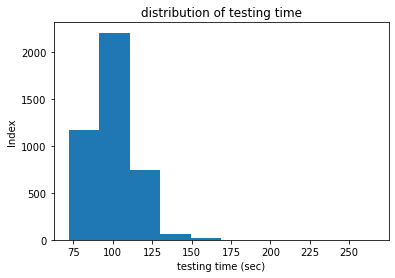

In [10]:
plt.hist(train_df['y'])
plt.title('distribution of testing time')
plt.xlabel('testing time (sec)')
plt.ylabel('Index')
plt.show()

From this chart we can observe that the time is nearly normaly distributed arround 100, with most testing taking between 75 and 150 seconds. We can further use a scatter plot to understand the values above 150 better.

**Scatter plot of dependent variable**

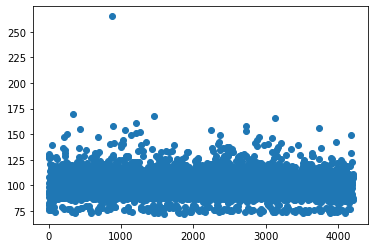

In [11]:
plt.scatter(range(len(train_df['y'])), train_df['y'])

- from this scatter plot we can observe what we've oserved before, the data is mostly distributed between 75 and 150 seconds. There is a point that is above 250, this point may represent a can that has features that most of the other cars don't. Because it's only one point and is so far away from the rest of the data we can consider it an outlier.
- Since we found one outlier is good practice making sure that there are no other outliers

In [12]:
# lets find out the 90th to 100th percentiles 
quantiles = [0.9,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99,1] 
for i in quantiles: 
    print(f"{i*100}th percentile: ",train_df["y"].quantile(i))

90.0th percentile:  115.25
91.0th percentile:  116.04840000000002
92.0th percentile:  116.89160000000001
93.0th percentile:  118.0376
94.0th percentile:  119.056
95.0th percentile:  120.806
96.0th percentile:  122.4
97.0th percentile:  125.89319999999998
98.0th percentile:  129.2992
99.0th percentile:  137.43040000000002
100th percentile:  265.32


In [13]:
# lets find out the 99th to 99.99th percentiles 
quantiles = np.arange(0.99,0.9999,0.001)
for i in quantiles: 
    print(f"{i*100}th percentile: ",train_df["y"].quantile(i))

99.0th percentile:  137.43040000000002
99.1th percentile:  139.09024
99.2th percentile:  140.18360000000004
99.3th percentile:  140.81639999999993
99.4th percentile:  142.6480000000001
99.5th percentile:  146.2304000000001
99.6th percentile:  149.0374399999998
99.7th percentile:  151.4276800000003
99.8th percentile:  154.68695999999994
99.9th percentile:  160.38328000000087


we will keep only the configurations that have less than 155 seconds test time.
Data points that are far from 99% percentile and less than 1 percentile are considered an outlier.

In [14]:
clean_train_df=train_df[train_df['y']<155]
print(f"Train data with outlier:{train_df.shape}")
print(f"Train data with outlier:{clean_train_df.shape}")
clean_train_df.head()

Train data with outlier:(4209, 378)
Train data with outlier:(4201, 378)


,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,130.81,k,v,at,a,d,u,j,o,...,0,0,1,0,0,0,0,0,0,0
1,6,88.53,k,t,av,e,d,y,l,o,...,1,0,0,0,0,0,0,0,0,0
2,7,76.26,az,w,n,c,d,x,j,x,...,0,0,0,0,0,0,1,0,0,0
3,9,80.62,az,t,n,f,d,x,l,e,...,0,0,0,0,0,0,0,0,0,0
4,13,78.02,az,v,n,f,d,h,d,n,...,0,0,0,0,0,0,0,0,0,0


**check for different types of data in the datase**

In [15]:
features=list(clean_train_df.columns)

cat_features=[]
binary_features=[]

for f in features:
    if clean_train_df[f].dtype=='object':
        cat_features.append(f)
    elif clean_train_df[f].dtype=='int' and f!='ID':
        binary_features.append(f)

print(f"Total categorical features: {len(cat_features)}")
print(f"Total binary features: {len(binary_features)}")

Total categorical features: 8
Total binary features: 368


There are:
- 8 categorical values, each one of those represent a custom feature  
- 1 float column representing the time that the car took to pass testing  
- 368 integer values which indicates all the tests performed on the car

/home/ec2-user/anaconda3/envs/JupyterSystemEnv/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  
/home/ec2-user/anaconda3/envs/JupyterSystemEnv/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if __name__ == '__main__':
/home/ec2-user/anaconda3/envs/JupyterSystemEnv/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; fo

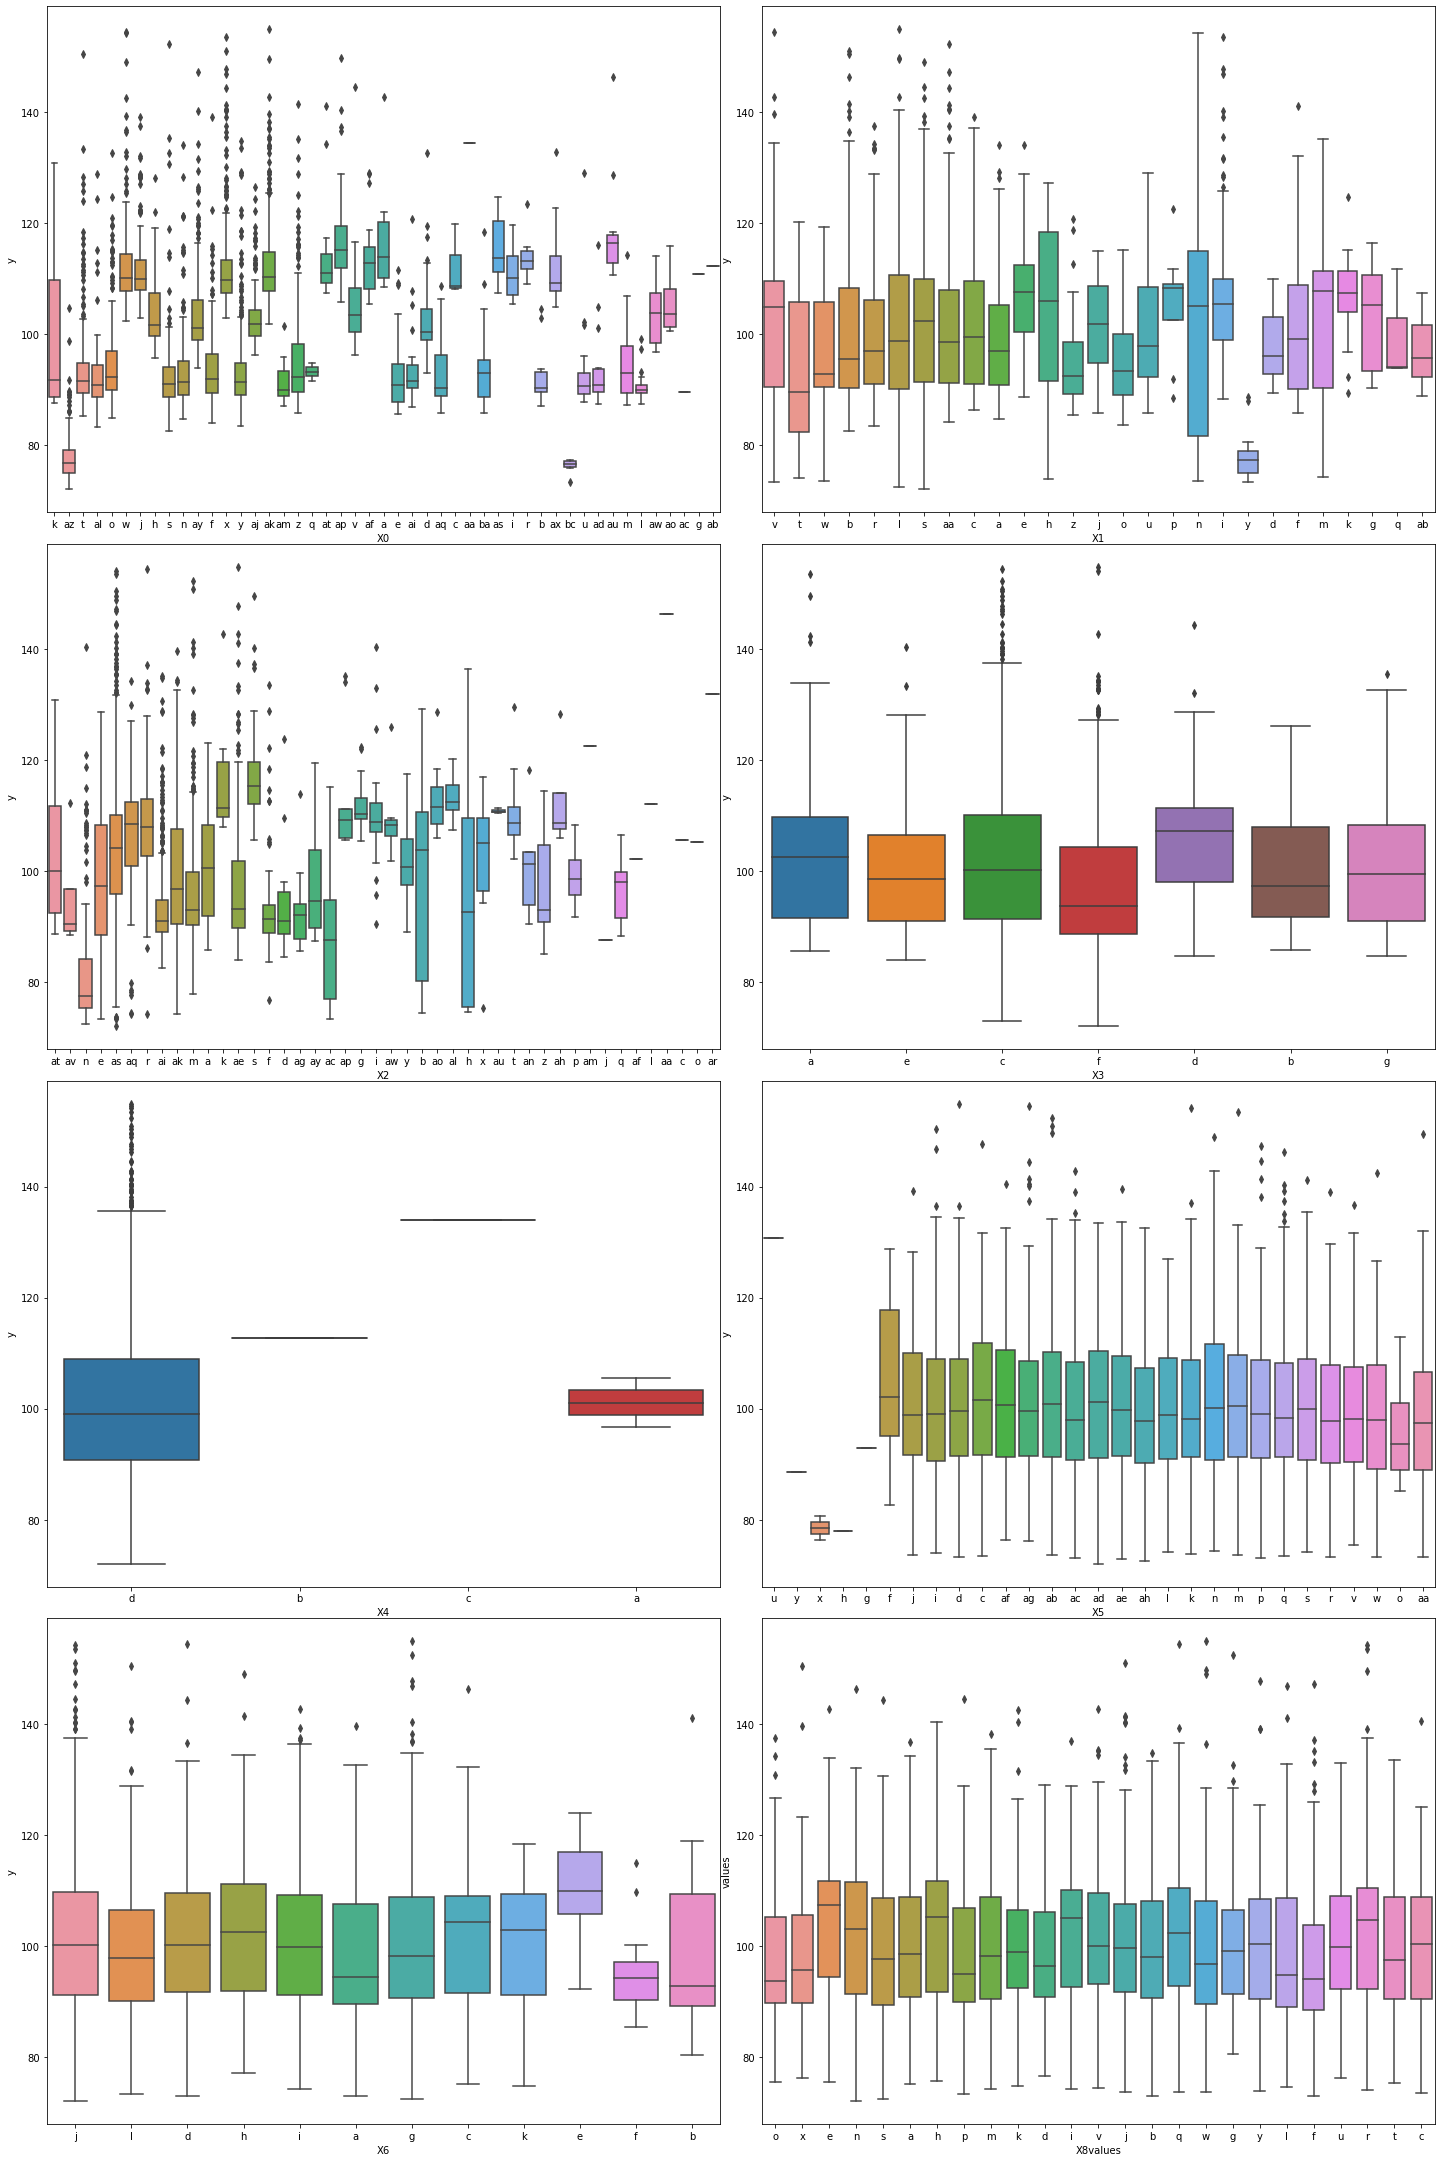

In [16]:
num_cat_features=int(len(cat_features)/2)
ax_column=0
ax_row=0

fig, ax = plt.subplots(num_cat_features,2, figsize=(20,30), constrained_layout=True) 
fig.tight_layout() 

for i in list(clean_train_df.columns):
    if(clean_train_df[i].dtype==np.object):
        sns.boxplot(y=clean_train_df['y'],x=clean_train_df[i], ax=ax[ax_row,ax_column])
        plt.xlabel(i + "values")
        plt.ylabel("values")
        
        if ax_column == 1:
            ax_column=0
            ax_row+=1
        elif ax_column == 0:
            ax_column+=1


- features X0,X1,X2,X3,X5,X6,X8 contain important information since the variance is quite high
- feature X4 has very little variance which might mean that it has less important information

### Analysis of Binary features

In [17]:
binary_train_data=clean_train_df[binary_features]
print(binary_train_data.shape)
binary_train_data.head()

(4201, 368)


,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,0,0,1,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


- calculate variance of all the binary features

In [18]:
var=[]
for f in binary_features:
    v=binary_train_data[f].var()
    var.append((f,v))

var_dict=dict(var)

In [19]:
var_df=pd.DataFrame(var_dict.keys(), columns=['feature'])
var_df['variance']=var_dict.values()

var_df

,feature,variance
0,X10,0.013156
1,X11,0.000000
2,X12,0.068971
3,X13,0.054510
4,X14,0.244908
...,...,...
363,X380,0.008030
364,X382,0.007561
365,X383,0.001664
366,X384,0.000476


In [20]:
var_df.describe()

,variance
count,368.000000
mean,0.061796
std,0.080493
min,0.000000
25%,0.003913
50%,0.021880
75%,0.087996
max,0.250040


*rephrase*

from above description minimum value of variance is zero and the maximum is 0.250040. Now I'm plotting a scatter plot for the above dataframe to check their distribution

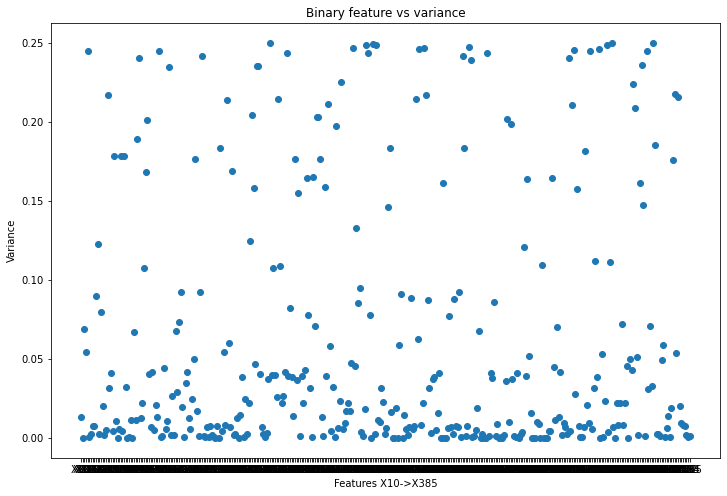

In [21]:
plt.figure(figsize=(12,8))
plt.scatter(var_df['feature'], var_df['variance'])
plt.title('Binary feature vs variance')
plt.xlabel('Features X10->X385')
plt.ylabel('Variance')
plt.show()

- above scatter plot shows that there are many values with zero variance
- also it suggests that there might be variables with same variance

In [22]:
zero_var_df=var_df[var_df['variance']==0]
zero_var_df.head()

,feature,variance
1,X11,0.0
81,X93,0.0
95,X107,0.0
217,X233,0.0
219,X235,0.0


In [23]:
print(f"The following {zero_var_df.shape[0]} features having 0 variance:\n")
print(zero_var_df['feature'].values)

The following 13 features having 0 variance:

['X11' 'X93' 'X107' 'X233' 'X235' 'X268' 'X289' 'X290' 'X293' 'X297'
 'X330' 'X339' 'X347']


- let's find out which features have duplicated variance

In [24]:
same_var_df=var_df[var_df['variance'].duplicated(keep='first').values]
same_var_df=same_var_df[same_var_df['variance']!=0]
same_var_df.head()

,feature,variance
24,X35,0.178138
26,X37,0.178138
28,X39,0.000238
46,X57,0.013156
64,X76,0.041456


In [25]:
print(f"There are {same_var_df.shape[0]} features having same variance:\n")
print(same_var_df['feature'].values)

There are 53 features having same variance:

['X35' 'X37' 'X39' 'X57' 'X76' 'X84' 'X94' 'X102' 'X113' 'X119' 'X120'
 'X122' 'X130' 'X134' 'X136' 'X146' 'X147' 'X157' 'X172' 'X194' 'X199'
 'X205' 'X213' 'X214' 'X216' 'X222' 'X226' 'X227' 'X232' 'X239' 'X242'
 'X243' 'X244' 'X245' 'X247' 'X248' 'X253' 'X254' 'X262' 'X263' 'X266'
 'X279' 'X296' 'X299' 'X302' 'X320' 'X324' 'X326' 'X360' 'X364' 'X365'
 'X382' 'X385']


From the above analysis I can conclude that I can drop:
- features with zero variance
- features with same variance
- features with very little variance because they will not impact the prediction by much

In [26]:
cat_drops=['X4']
zero_drops=list(zero_var_df['feature'].values)
same_drops=list(same_var_df['feature'].values)

all_binary_drops=zero_drops+same_drops
drop_feat=cat_drops+all_binary_drops

print(f"These are the total {len(drop_feat)} features I can drop:\n\n", drop_feat)

These are the total 67 features I can drop:

 ['X4', 'X11', 'X93', 'X107', 'X233', 'X235', 'X268', 'X289', 'X290', 'X293', 'X297', 'X330', 'X339', 'X347', 'X35', 'X37', 'X39', 'X57', 'X76', 'X84', 'X94', 'X102', 'X113', 'X119', 'X120', 'X122', 'X130', 'X134', 'X136', 'X146', 'X147', 'X157', 'X172', 'X194', 'X199', 'X205', 'X213', 'X214', 'X216', 'X222', 'X226', 'X227', 'X232', 'X239', 'X242', 'X243', 'X244', 'X245', 'X247', 'X248', 'X253', 'X254', 'X262', 'X263', 'X266', 'X279', 'X296', 'X299', 'X302', 'X320', 'X324', 'X326', 'X360', 'X364', 'X365', 'X382', 'X385']


### Data Preprocessing

In [27]:
def preprocess_categorical(data, IDs):
    cat_features=[]
    binary_features=[]
    
    for f in data.columns:
        if data[f].dtype=='object':
            cat_features.append(f)
        elif data[f].dtype=='int' and f!='ID':
            binary_features.append(f)
    
    cat_df=data[cat_features]
    bin_df=data[binary_features]
    bin_df.insert(0, 'ID', IDs.values) 
    
    for feature in cat_features:
        encoder=LabelEncoder()
        cat_df[feature]=encoder.fit_transform(cat_df[feature].values)
        
    cat_df=pd.DataFrame(cat_df, columns=cat_features)
    cat_df.insert(0,'ID',IDs.values)
    
    new_data=pd.merge(cat_df,bin_df,on='ID',how="left")
    
    if 'y' in data.columns:
        labels=data['y']
        
        return new_data,labels
    else:
        return new_data

### Preprocess Train set

In [30]:
final_train_df=clean_train_df.drop(drop_feat,axis=1)
final_train_df=final_train_df.drop('ID', axis=1)
train_ID=clean_train_df['ID'].copy()

print(f"Before removing non informative features:{clean_train_df.shape}")
print(f"After removing non informative features:{final_train_df.shape}")
final_train_df.head()

Before removing non informative features:(4201, 378)
After removing non informative features:(4201, 310)


,y,X0,X1,X2,X3,X5,X6,X8,X10,X12,...,X373,X374,X375,X376,X377,X378,X379,X380,X383,X384
0,130.81,k,v,at,a,u,j,o,0,0,...,0,0,0,0,1,0,0,0,0,0
1,88.53,k,t,av,e,y,l,o,0,0,...,0,0,1,0,0,0,0,0,0,0
2,76.26,az,w,n,c,x,j,x,0,0,...,0,0,0,0,0,0,0,0,0,0
3,80.62,az,t,n,f,x,l,e,0,0,...,0,0,0,0,0,0,0,0,0,0
4,78.02,az,v,n,f,h,d,n,0,0,...,0,0,0,0,0,0,0,0,0,0


### Encode testing dataset

In [31]:
# get the encoded and normalized categorical features and labels
X_train, y_train= preprocess_categorical(final_train_df, train_ID)
X_train.head()

/home/ec2-user/anaconda3/envs/JupyterSystemEnv/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,ID,X0,X1,X2,X3,X5,X6,X8,X10,X12,...,X373,X374,X375,X376,X377,X378,X379,X380,X383,X384
0,0,32,23,17,0,24,9,14,0,0,...,0,0,0,0,1,0,0,0,0,0
1,6,32,21,19,4,28,11,14,0,0,...,0,0,1,0,0,0,0,0,0,0
2,7,20,24,34,2,27,9,23,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9,20,21,34,5,27,11,4,0,0,...,0,0,0,0,0,0,0,0,0,0
4,13,20,23,34,5,12,3,13,0,0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
final_test = test_df.drop(drop_feat, axis=1)
final_test = final_test.drop('ID', axis=1)
test_ID = test_df['ID'].copy()
print(f"Before removing non informative features:{test_df.shape}")
print(f"After removing non informative features:{final_test.shape}")
final_test.head()

Before removing non informative features:(4209, 377)
After removing non informative features:(4209, 309)


,X0,X1,X2,X3,X5,X6,X8,X10,X12,X13,...,X373,X374,X375,X376,X377,X378,X379,X380,X383,X384
0,az,v,n,f,t,a,w,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,t,b,ai,a,b,g,y,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,az,v,as,f,a,j,j,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,az,l,n,f,z,l,n,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,w,s,as,c,y,i,m,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [33]:
### Original Set

In [34]:
X_train = X_train.drop('ID', axis=1)
X_train, X_cv, y_train, y_cv=train_test_split(X_train,y_train,test_size=0.2,random_state=42)

X_test=preprocess_categorical(final_test,test_ID)
X_test=X_test.drop('ID',axis=1)

print("Train set:")
print(X_train.shape)
print(y_train.shape)
print("CV set:")
print(X_cv.shape)
print(y_cv.shape)
print("Test set:")
print(X_test.shape)

Train set:
(3360, 309)
(3360,)
CV set:
(841, 309)
(841,)
Test set:
(4209, 309)


/home/ec2-user/anaconda3/envs/JupyterSystemEnv/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### PCA

In [42]:
components=10
categories = ['X0','X1', 'X2', 'X3', 'X5','X6', 'X8'] 

pca=PCA(n_components=components,random_state=420)
pca_train=pca.fit_transform(X_train.drop(categories, axis=1))
pca_cv=pca.transform(X_cv.drop(categories,axis=1))
pca_test=pca.transform(X_test.drop(categories,axis=1))

print(pca_train.shape)
print(pca_cv.shape)
print(pca_test.shape)

(3360, 10)
(841, 10)
(4209, 10)


### XGBoost Regressor

In [41]:
xgb=XGBRegressor(random_state=42,n_jobs=-1)

parameters = {'learning_rate':[0.01,0.05,0.1,1], 
      'n_estimators':[100,150,200,500], 
      'max_depth':[2,3,5,10], 
      'colsample_bytree':[0.1,0.5,0.7,1], 
      'subsample':[0.2,0.3,0.5,1]} 
lr_grid = GridSearchCV(xgb,parameters, cv=10)
lr_grid.fit(pca_train, y_train)
print('Hyper Parameters for XGBoost Regressor:\\n',lr_grid.best_params_)
print('Score for Hyper Parameters from Grid Search:',lr_grid.best_score_)
lr_grid.cv_results_

Hyper Parameters for XGBoost Regressor:\n {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 500, 'subsample': 0.5}
Score for Hyper Parameters from Grid Search: 0.5752811184319422


{'mean_fit_time': array([0.04904575, 0.04865315, 0.05536954, ..., 2.71145232, 2.75720973,
        0.76675448]),
 'std_fit_time': array([1.03761992e-02, 7.28373094e-04, 4.89198336e-04, ...,
        8.14287206e-01, 4.51549166e-02, 1.59280001e-02]),
 'mean_score_time': array([0.00254571, 0.00254312, 0.00253351, ..., 0.00913863, 0.00884383,
        0.00367393]),
 'std_score_time': array([5.94012844e-05, 4.59125351e-05, 3.26849264e-05, ...,
        1.08552312e-04, 5.79787760e-05, 5.76774114e-05]),
 'param_colsample_bytree': masked_array(data=[0.1, 0.1, 0.1, ..., 1, 1, 1],
              mask=[False, False, False, ..., False, False, False],
        fill_value='?',
             dtype=object),
 'param_learning_rate': masked_array(data=[0.01, 0.01, 0.01, ..., 1, 1, 1],
              mask=[False, False, False, ..., False, False, False],
        fill_value='?',
             dtype=object),
 'param_max_depth': masked_array(data=[2, 2, 2, ..., 10, 10, 10],
              mask=[False, False, False, ...

In [43]:
X_full_train_pca = np.vstack((pca_train, pca_cv))
y_full_train = np.vstack((y_train.values.reshape(-1,1), y_cv.values.reshape(-1,1)))

In [44]:
{'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 500, 'subsample': 0.5}

xgb = XGBRegressor(n_estimators = lr_grid.best_params_['n_estimators'],
               learning_rate = lr_grid.best_params_['learning_rate'],
               max_depth = lr_grid.best_params_['max_depth'],
               subsample = lr_grid.best_params_['subsample'],
               colsample_bytree = lr_grid.best_params_['colsample_bytree'],
               random_state=42,n_jobs=-1)
xgb.fit(X_full_train_pca, y_full_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=500, n_jobs=-1,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.5,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [48]:
pred_train = xgb.predict(X_full_train_pca)
train_score = r2_score(y_full_train, pred_train)
print(f"For max_depth={lr_grid.best_params_['max_depth']}, Train R2 = {train_score}")

For max_depth=5, Train R2 = 0.6574563976195873


In [55]:
pred_test = xgb.predict(pca_test)
submission_xgb=pd.DataFrame() 
submission_xgb['y'] = pred_test
submission_xgb.head()

,y
0,76.819954
1,96.072861
2,80.733543
3,76.981941
4,111.566040
